In [ ]:
!pip install scikit-learn

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from gensim.models import Word2Vec

In [ ]:
data = pd.read_csv('test_data_ECG.csv')

#Предобработка данных

clear_data = data.rename(columns={'eeg_time ': 'eeg_time', 'eeg_date ': 'eeg_date'})

#Убираем аномальные данные
columns_to_check = ['rr_interval', 'p_onset', 'p_end', 'qrs_onset', 'qrs_end', 't_end', 'p_axis', 'qrs_axis', 't_axis']
clear_data = clear_data[(clear_data[columns_to_check] < 2000).all(axis=1)]
clear_data = clear_data[(clear_data['p_onset'] < clear_data['p_end']) & (clear_data['qrs_onset'] < clear_data['qrs_end'])]

#Сортируем данные по пациентам
clear_data = clear_data.sort_values(by='subject_id', ascending=True)

#Переводим дату из строки в формат даты
clear_data['eeg_time'] = pd.to_datetime(clear_data['eeg_time'], format='%I:%M %p').dt.time


#Обрабатываем текстовые описания репортов
reports = [f'report_{x}' for x in range(18)]
clear_data['report_0'] = clear_data[reports].astype(str).agg(' '.join, axis=1)
clear_data['report_0'] = clear_data['report_0'].str.replace(r'\bnan\b', '', regex=True).str.replace(r'\s+', ' ', regex=True).str.strip()
clear_data.rename(columns={'report_0': 'report'}, inplace=True)
reports_to_drop = [f'report_{x}' for x in range(1, 18)]
clear_data = clear_data.drop(reports_to_drop, axis=1)

clear_data

# Превращаем столбец с текстовым отчетом в число с помощью Word2Vec

words = [text.split() for text in clear_data['report']] # Разбиваем  на токены
w2v_model = Word2Vec(words, vector_size=100, window=5, min_count=1, workers=4) # Обучаем модель Word2Vec

def get_sentence_embedding(sentence): # Функция для получения среднего эмбеддинга строки
    words = sentence.split()
    word_vectors = [w2v_model.wv[word] for word in words if word in w2v_model.wv]
    if word_vectors:
        return np.mean(word_vectors, axis=0)  # Усреднённый вектор
    else:
        return np.zeros(w2v_model.vector_size)  # Нулевой вектор, если слова нет в модели

clear_data['report'] = clear_data['report'].apply(lambda x: get_sentence_embedding(x).mean()) # Применяем функцию ко всей колонке и переводим каждый вектор в одно число

clear_data

,subject_id,Count_subj,study_id,cart_id,Healthy_Status,eeg_time,eeg_date,report,bandwidth,filtering,rr_interval,p_onset,p_end,qrs_onset,qrs_end,t_end,p_axis,qrs_axis,t_axis
4448,10001877,4,40056908,6919786,0,10:32:00,27.06.2014,0.049253,0.005-150 Hz,60 Hz notch Baseline filter,1034,40,120,152,248,568,-45,28,-18
8586,10002155,13,40107403,6578848,0,10:15:00,29.09.2010,0.039246,0.05-150 Hz,60 Hz notch Baseline filter,983,40,148,212,306,622,14,19,5
1917,10002221,13,40024801,6903271,0,04:14:00,12.04.2015,0.032659,0.005-150 Hz,Baseline filter,769,40,134,268,350,704,39,-3,78
3849,10003757,2,40049308,6672155,0,19:02:00,22.09.2011,0.040821,0.005-150 Hz,60 Hz notch Baseline filter,759,40,156,212,318,614,49,-7,125
8139,10004422,7,40102219,6228095,0,03:58:00,05.01.2010,0.026396,0.005-150 Hz,60 Hz notch Baseline filter,769,40,126,184,320,618,54,-58,60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
899,19996061,3,40011859,6154636,0,23:44:00,03.02.2013,-0.014344,0.005-150 Hz,60 Hz notch Baseline filter,500,40,134,184,276,492,47,19,47
5170,19997367,36,40065685,6752764,0,22:57:00,19.11.2010,0.045298,0.005-150 Hz,60 Hz notch Baseline filter,495,40,134,154,248,472,63,37,-158
2458,19997367,36,40031683,6919786,0,09:40:00,04.11.2011,0.022872,0.005-150 Hz,60 Hz notch Baseline filter,1071,40,128,234,338,704,20,-25,17
8002,19997367,36,40100360,6245150,0,08:32:00,17.10.2015,0.037104,0.005-150 Hz,60 Hz notch Baseline filter,923,40,154,172,268,616,44,-41,117


In [ ]:
Y = clear_data['Healthy_Status'] # таргет
X = clear_data.iloc[:, :35] # переменные

# Разбиваем данные на обучающую и тестовую выборки
RANDOM_SEED = 45

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.70, random_state=RANDOM_SEED, stratify=Y)
print('Распределение Y_train по классам 0 и 1 соответственно:', np.bincount(Y_train))
print('Распределение Y_test по классам 0 и 1 соответственно:', np.bincount(Y_test))

Распределение Y_train по классам 0 и 1 соответственно: [3527 1405]
Распределение Y_test по классам 0 и 1 соответственно: [1512  602]


In [ ]:
#AUTO ML -----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
#В данном блоке мы применяем auto ml к нашему учебному датасету

In [ ]:
!pip install -U lightautoml

In [ ]:
# Импорт библиотек для auto ml
from lightautoml.automl.presets.tabular_presets import TabularAutoML
from lightautoml.tasks import Task
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [ ]:
#Подготовим данные к auto ml
auto_data = clear_data[['rr_interval', 'p_onset', 'p_end', 'qrs_onset', 'qrs_end', 't_end', 'p_axis', 'qrs_axis', 't_axis', 'Healthy_Status']].copy()

Y_auto = auto_data['Healthy_Status'] # таргет
X_auto = auto_data.iloc[:, :9] # переменные

# Разбиваем данные на обучающую и тестовую выборки
RANDOM_SEED = 41

X_tr_auto, X_t_auto, Y_tr_auto, Y_t_auto = train_test_split(X_auto, Y_auto, train_size=0.70, random_state=RANDOM_SEED, stratify=Y_auto)
print('Распределение Y_train по классам 0 и 1 соответственно:', np.bincount(Y_tr_auto))
print('Распределение Y_test по классам 0 и 1 соответственно:', np.bincount(Y_t_auto))

Распределение Y_train по классам 0 и 1 соответственно: [3527 1405]
Распределение Y_test по классам 0 и 1 соответственно: [1512  602]


In [ ]:
# Склеиваем признаки и таргеты в один датафрейм
auto_train_df = X_tr_auto
auto_train_df['Healthy_Status'] = Y_tr_auto
auto_test_df = X_t_auto
auto_test_df['Healthy_Status'] = Y_t_auto

# Обучаем модель
auto_ml = TabularAutoML(task = Task(name = 'binary', metric = 'auc'))
oof_preds = auto_ml.fit_predict(auto_train_df, roles = {'target': 'Healthy_Status'}).data


In [ ]:
# Предсказываем
test_preds = auto_ml.predict(auto_test_df).data

# Порог отсечения - 0.5
for i in range(len(test_preds)):
  if test_preds[i][0] > 0.5:
    test_preds[i] = 1
  else:
    test_preds[i] = 0

# Вычисляем F1-меру с помощью confusion matrix
cm = confusion_matrix(Y_t_auto, test_preds)
TN, FP, FN, TP = cm.ravel()
precision = TP / (TP + FP) if (TP + FP) != 0 else 0
recall = TP / (TP + FN) if (TP + FN) != 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
print("Confusion matrix:", cm)
print("F1-Score:", f1_score)


Confusion matrix: [[1314  198]
 [ 236  366]]
F1-Score: 0.6277873070325901


In [ ]:
#AUTO ML END -------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
#LSTM_Test_Sample --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
#В данном блоке продемонстрирован пример применения LSTM модели

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
import matplotlib.pyplot as plt

Epoch 1/500


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - accuracy: 0.0000e+00 - loss: 3.7141
Epoch 2/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.1321 - loss: 3.7045 
Epoch 3/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.0771 - loss: 3.6947 
Epoch 4/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.0608 - loss: 3.6833
Epoch 5/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.0608 - loss: 3.6633
Epoch 6/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.0608 - loss: 3.6264 
Epoch 7/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.0608 - loss: 3.5859
Epoch 8/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.0712 - loss: 3.5528
Epoch 9/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.0608 - loss: 3.5501 
Epoch 10/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.0504 - loss: 3.5624
Epoch 11/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.0875 - loss: 3.4944
Epoch 12/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.0979 - loss: 

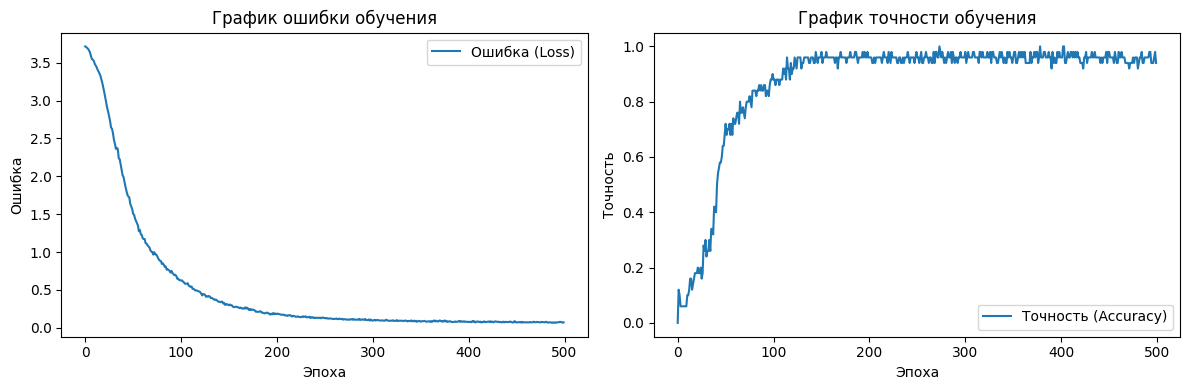

Следующее слово для 'Deep learning': is


In [ ]:
# 1. Подготовка текстового датасета
text = """
Deep learning is a subset of machine learning. Machine learning models can learn patterns.
Natural language processing is a key component of AI. AI can analyze vast amounts of data.
Neural networks are used in many AI applications. Data science combines math and computing.
Deep neural networks can achieve state-of-the-art results. AI is transforming industries.
"""

# 2. Токенизация текста и преобразование в числовой формат
tokenizer = Tokenizer()
tokenizer.fit_on_texts([text])
total_words = len(tokenizer.word_index) + 1  # Включаем +1 для использования всех слов

# Создаем обучающие последовательности
input_sequences = []
for line in text.split('.'):
    token_list = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)

# Приведение всех последовательностей к одинаковой длине
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre')

# Создаем входные (X) и выходные (y) данные
X = input_sequences[:, :-1]
y = input_sequences[:, -1]
y = to_categorical(y, num_classes=total_words)

# 3. Создание улучшенной модели LSTM
model = Sequential()
model.add(Embedding(total_words, 100, input_length=max_sequence_len-1))
model.add(LSTM(150, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(100))
model.add(Dense(total_words, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Обучение модели
history = model.fit(X, y, epochs=500, verbose=1)

# Построим график точности и ошибки обучения
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Ошибка (Loss)')
plt.xlabel('Эпоха')
plt.ylabel('Ошибка')
plt.title('График ошибки обучения')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Точность (Accuracy)')
plt.xlabel('Эпоха')
plt.ylabel('Точность')
plt.title('График точности обучения')
plt.legend()
plt.tight_layout()
plt.show()

# 4. Функция для предсказания следующего слова
def predict_next_word(model, tokenizer, text, max_sequence_len):
    token_list = tokenizer.texts_to_sequences([text])[0]
    token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
    predicted_probs = model.predict(token_list, verbose=0)
    predicted_index = np.argmax(predicted_probs)

    for word, index in tokenizer.word_index.items():
        if index == predicted_index:
            return word
    return None

# Пример предсказания следующего слова
seed_text = "Deep learning"
next_word = predict_next_word(model, tokenizer, seed_text, max_sequence_len)
print(f"Следующее слово для '{seed_text}': {next_word}")

In [ ]:
#LSTM_Test_Sample END ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
#LSTM_BioMed -------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
#В данном блоке LSTM модель применяется к нашему тестовому датасету

In [ ]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Исходные данные
df = clear_data

# Названия столбцов признаков и целевой переменной
feature_columns = ['report', 'rr_interval', 'p_onset', 'p_end', 'qrs_onset', 'qrs_end', 't_end', 'p_axis', 'qrs_axis', 't_axis']
target_column = 'Healthy_Status'  # Название столбца целевой переменной

# Стандартизация признаков
scaler = StandardScaler()
df[feature_columns] = scaler.fit_transform(df[feature_columns])

# Параметры временного ряда
time_step = 5  # Количество временных шагов для анализа

# Функция создания временных рядов
def create_dataset(data, time_step=1, target_col=None):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data.iloc[i:i + time_step][feature_columns].values)  # Признаки
        y.append(data.iloc[i + time_step][target_col])                # Целевая переменная
    return np.array(X), np.array(y)

# Проверяем наличие целевого столбца в данных
if target_column not in df.columns:
    raise ValueError(f"Целевая переменная '{target_column}' отсутствует в DataFrame.")

# Создание временных рядов для LSTM
X, y = create_dataset(df, time_step, target_col=target_column)

# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Создание модели LSTM
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(50))
model.add(Dense(1, activation='sigmoid'))  # Так как задача бинарной классификации

# Компиляция модели
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Обучение модели
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=1)

# Прогнозирование и оценка
y_pred = (model.predict(X_test) > 0.5).astype(int)  # Прогнозирование классов
accuracy = accuracy_score(y_test, y_pred)

print(f"Точность модели на тестовом наборе: {accuracy * 100:.2f}%")

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


176/176 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.7195 - loss: nan - val_accuracy: 0.7005 - val_loss: nan
Epoch 2/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7263 - loss: nan - val_accuracy: 0.7005 - val_loss: nan
Epoch 3/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7155 - loss: nan - val_accuracy: 0.7005 - val_loss: nan
Epoch 4/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7133 - loss: nan - val_accuracy: 0.7005 - val_loss: nan
Epoch 5/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.7153 - loss: nan - val_accuracy: 0.7005 - val_loss: nan
Epoch 6/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.7170 - loss: nan - val_accuracy: 0.7005 - val_loss: nan
Epoch 7/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7124 - loss: nan - val_accuracy: 0.7005 - val_loss: nan
Epoch 8/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7206 - loss: nan - val_accuracy: 0.7005 - val_loss: nan
Epoch 9/50
176/176 ━━━━━━━━━━━━━━

In [ ]:
#----------------------------------------------------------------------------------
#GAMA AutoML

In [ ]:
!pip install gama

In [ ]:
#Подготовим данные к auto ml
auto_data = clear_data[['rr_interval', 'p_onset', 'p_end', 'qrs_onset', 'qrs_end', 't_end', 'p_axis', 'qrs_axis', 't_axis', 'Healthy_Status']].copy()

Y_auto = auto_data['Healthy_Status'] # таргет
X_auto = auto_data.iloc[:, :9] # переменные

# Разбиваем данные на обучающую и тестовую выборки
RANDOM_SEED = 0

X_train, X_test, y_train, y_test = train_test_split(X_auto, Y_auto, train_size=0.70, random_state=RANDOM_SEED, stratify=Y_auto)
print('Распределение Y_train по классам 0 и 1 соответственно:', np.bincount(y_train))
print('Распределение Y_test по классам 0 и 1 соответственно:', np.bincount(y_test))

Распределение Y_train по классам 0 и 1 соответственно: [3527 1405]
Распределение Y_test по классам 0 и 1 соответственно: [1512  602]


In [ ]:
from sklearn.metrics import log_loss, accuracy_score
from gama import GamaClassifier

automl = GamaClassifier(max_total_time=180, store="nothing")
print("Starting `fit` which will take roughly 3 minutes.")
automl.fit(X_train, y_train)

INFO:gama.gama:Using GAMA version 23.0.0.post1.
INFO:gama.gama:INIT:GamaClassifier(search_space={'alpha': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0], 'fit_prior': [True, False], 'min_samples_split': range(2, 21), 'min_samples_leaf': range(1, 21), <class 'sklearn.naive_bayes.GaussianNB'>: {}, <class 'sklearn.naive_bayes.BernoulliNB'>: {'alpha': [], 'fit_prior': []}, <class 'sklearn.naive_bayes.MultinomialNB'>: {'alpha': [], 'fit_prior': []}, <class 'sklearn.tree._classes.DecisionTreeClassifier'>: {'criterion': ['gini', 'entropy'], 'max_depth': range(1, 11), 'min_samples_split': [], 'min_samples_leaf': []}, <class 'sklearn.ensemble._forest.ExtraTreesClassifier'>: {'n_estimators': [100], 'criterion': ['gini', 'entropy'], 'max_features': array([0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55,
       0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]), 'min_samples_split': [], 'min_samples_leaf': [], 'bootstrap': [True, False]}, <class 'sklearn.ensemble._forest.RandomForestCla

Starting `fit` which will take roughly 3 minutes.


INFO:gama.search_methods.async_ea:Starting EA with new population.
DEBUG:gama.utilities.generic.async_evaluator:Signaling 1 subprocesses to stop.
INFO:gama.gama:Search phase evaluated 115 individuals.
INFO:gama.utilities.generic.timekeeper:STOP: search AsyncEA after 161.1005s.
INFO:gama.utilities.generic.timekeeper:START: postprocess BestFitPostProcessing
INFO:gama.utilities.generic.timekeeper:STOP: postprocess BestFitPostProcessing after 1.4809s.


In [ ]:
label_predictions = automl.predict(X_test)
probability_predictions = automl.predict_proba(X_test)

print('accuracy:', accuracy_score(y_test, label_predictions))
print('log loss:', log_loss(y_test, probability_predictions))
# the `score` function outputs the score on the metric optimized towards (by default, `log_loss`)
print('log_loss', automl.score(X_test, y_test))

accuracy: 0.7871333964049196
log loss: 0.38280514454049325
log_loss 0.38280514454049325


In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

test_preds = label_predictions.data

# Порог отсечения - 0.5
for i in range(len(test_preds)):
  if test_preds[i] > 0.5:
    test_preds[i] = 1
  else:
    test_preds[i] = 0

# Вычисляем F1-меру с помощью confusion matrix
cm = confusion_matrix(y_test, test_preds)
TN, FP, FN, TP = cm.ravel()
precision = TP / (TP + FP) if (TP + FP) != 0 else 0
recall = TP / (TP + FN) if (TP + FN) != 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
print("Confusion matrix:", cm)
print("F1-Score:", f1_score)

Confusion matrix: [[1232  280]
 [ 170  432]]
F1-Score: 0.6575342465753425


In [ ]:
#GAMA AutoML END
#-------------------------------------------------------------------------------